**Created by Muhammed El-Yamani**

**🚀 Clothing type classifier Techsquadeg**

**15 Jun 2022**


# Problem Statment

Assume that we would like to create **a clothing type classifier**. 

You are required to select one of the **freely available datasets** and **create an initial model** to deliver a prototype of the solution. 

It’s recommended to use google colab for this task since it’s free and easily shareable. 

**Deliverables:**


1. A Github repository containing your solution

2. A ReadMe detailing the steps you took to solve the problem, your approach, your data handling techniques, any problems you faced, and the results of your tests.

3. A summary of the results and metrics you choose to evaluate

4. A presentation to illustrate your results (will be discussed during the evaluation process)


-----------------------------------------------------
 



**Notes:**


1.   Use proper data handling and data loading: Done 

2.   Explore multiple solutions and showcase why you chose the final one
Be clear on your choice of metrics and why you chose them.

3. Make sure to write clean, modular, and well-documented code.: Done 

4. Make sure to keep your approach optimum as much as possible for deployment, with minimal model size and the number of FLOPS.


You are not expected to reach optimal results, but it is very critical for you to showcase how you approach the problem and outline your thought process.


Best of luck


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/jobs_assignments/techsquadeg

## Import libraries

In [8]:
import logging
logging.basicConfig( level=logging.INFO, format="%(message)s")

import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms, models
import json
from tqdm import tqdm
import logging
from pathlib import Path
import re
import pandas as pd
import os
import pathlib
from tqdm import tqdm
import shutil
import matplotlib as mpl
# define Train function
import wandb

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12) 
%matplotlib inline


mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

In [9]:
# helper files
from utils.scores import calc_accuracy
from utils import utils, generate_images
from utils.load_dataset import get_dataset_dataloader
from evaluate import evaluate, get_predictions
from net_utils import Net_Utility, load_checkpoint
# from unet import UNet
# from net_utility import Net_Utility


## Global variables

In [10]:
LOCAL_DATASET_PATH='dataset'
LOCAL_RAW_DATASET_PATH = 'source_dataset'
CHECKPOINT_PATH='checkpoint'
GENERATE_IMAGES=False

In [11]:
DEBUG=False
KEEP_DATA_FACTOR=0.1
# TYPE_LOAD_MODEL: load_best | load_interrupted | load_last
TYPE_LOAD_MODEL='load_best'
PRINT_EVERY=None
DELAY_EPOCHS_EARLY_STOPPING=2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
N_CLASSES = 46
SEED=0
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
# MULTIPLE_TRAIN_SIZE = 2
LOADER_ARGS = dict(batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
LEARNING_RATE = 1e-3
IS_TRAIN = True
print(f'Using device {DEVICE}')

Using device cuda


In [12]:
if DEBUG:
    print("Debug mode")
    KEEP_DATA_FACTOR=0.001
    EPOCHS = 1
    PRINT_EVERY=1


## Preparing Datasets

- source_dataset/Anno_coarse/
  - list_category_cloth.txt
  - list_category_img.txt

- source_dataset/Eval
  - list_eval_partition.txt

- source_dataset/Img
  - img.zip

In [13]:
generate_images.prepare_images(LOCAL_RAW_DATASET_PATH, LOCAL_DATASET_PATH, GENERATE_IMAGES)

Notes README.md from source_dataset:
1. The long side of images are resized to 300;
2. The aspect ratios of original images are kept unchanged.

## Data loaders 

- transforms
- augmentation

In [14]:
data_loaders= dict()
image_datasets= dict()
data_transforms= dict()
train_dataset, train_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='train', aug_train=True, keep_data_factor= KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
val_dataset, val_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='val', aug_train=True, keep_data_factor= KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
test_dataset, test_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='test', aug_train=True, keep_data_factor= KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)

train dataset: 209 images
val dataset: 40 images
test dataset: 40 images


In [15]:
image_datasets={'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
data_loaders={'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

In [16]:
classes_names = image_datasets['train'].class_names
print("number of classes in train datasets: ", len(classes_names))

number of classes in train datasets:  46


In [17]:
print("number of classes in val datasets: ", len(image_datasets['val'].class_names))

number of classes in val datasets:  40


In [18]:
print("number of classes in tes datasets: ", len(image_datasets['test'].class_names))

number of classes in tes datasets:  40


In [19]:
print("Check the order of indices for the datasets")

n1 = np.sum(image_datasets['train'].class_names ==
            image_datasets['val'].class_names)
n2 = np.sum(image_datasets['train'].class_names ==
            image_datasets['test'].class_names)
if n1 + n2 == 2*N_CLASSES:
    print("Every thing is ok")
else:
    raise


Check the order of indices for the datasets


ValueError: shape mismatch: objects cannot be broadcast to a single shape

## Explore The Dataset

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Explore The Datase:</u></b><br>
 
* <i>RGB images</i><br>
* <i>train dataset: 209222 images</i><br>
* <i>val dataset: 40000 images</i><br>
* <i>test dataset: 40000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes not balanced with skewed graph </i><br>
* <i>The class **Dress** has the greatest size with **52138**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>
* <i>The image has more than label but annotated with only label. So there is noise in the images. </i><br>

----------------------------------------------------------------

**Solution for imbalanced**

We can solve this problem by making augmentation to generate more datasets for the classes with the weights of their distribution.


We have 52138 images for Dress. So the new data will be 52138*46 ~ 2.4e6. 

**The advantages:**

- The model will not be biased towards some classes and perhaps we get better results.

From 2.1e4   to   2.4e6.

I will let this approach for future works.

----------------------------------------------------------------

**The original dataset takes great time to train**

The original data has a large dataset and takes a very long time to evaluate, almost 2 hours per validation set. 

So I decided to work only on 10% of the original data to speed up my work.

And this approach has another advantage which tries to solve the imbalanced data, as we see in the distributions below. 

----------------------------------------------------------------

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>After preprocessing & Augmentation & taking the most important data:</u></b><br>
 
* <i>Normalaized RGB images</i><br>
* <i>train dataset: 20922 images</i><br>
* <i>val dataset: 4000 images</i><br>
* <i>test dataset: 4000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes almost balanced better than original </i><br>
* <i>The class **Dress** has the greatest size with **723**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>
* <i>Images 3 channels RGB float range(-2.1179, 2.6400) </i><br>
* <i>Labels int range(0, 45) </i><br>
* <i>Class names images  </i><br>



<table>
  <tr>
    <td>Anorak</td>
    <td>Blazer</td>
    <td>Blouse</td>
    <td>Bomber</td>
    <td>Trunks</td>
  </tr>
    <tr>
    <td>Button-Down</td>
    <td>Caftan</td>
    <td>Capris</td>
    <td>Cardigan</td>
    <td>Chinos</td>
  </tr>
    <tr>
    <td>Coat</td>
    <td>Coverup</td>
    <td>Culottes</td>
    <td>Cutoffs</td>
    <td>Dress</td>
  </tr>
  <tr>
    <td>Flannel</td>
    <td>Gauchos</td>
    <td>Halter</td>
    <td>Henley</td>
    <td>Hoodie</td>
  </tr>
    <tr>
    <td>Jacket</td>
    <td>Jeans</td>
    <td>Jeggings</td>
    <td>Jersey</td>
    <td>Jodhpurs</td>
  </tr>
    <tr>
    <td>Joggers</td>
    <td>Jumpsuit</td>
    <td>Kaftan</td>
    <td>Kimono</td>
    <td>Leggings</td>
  </tr>
    <tr>
    <td>Onesie</td>
    <td>Parka</td>
    <td>Peacoat</td>
    <td>Poncho</td>
    <td>Robe</td>
  </tr>
    <tr>
    <td>Romper</td>
    <td>Sarong</td>
    <td>Shorts</td>
    <td>Skirt</td>
    <td>Sweater</td>
  </tr>
    <tr>
    <td>Sweatpants</td>
    <td>Sweatshorts</td>
    <td>Tank</td>
    <td>Tee</td>
    <td>Top</td>
    <td>Turtleneck</td>
  </tr>
</table>



In [ ]:
# image_datasets['train'].plot_distribution()

In [ ]:
# image_datasets['val'].plot_distribution()

In [ ]:
# image_datasets['test'].plot_distribution()

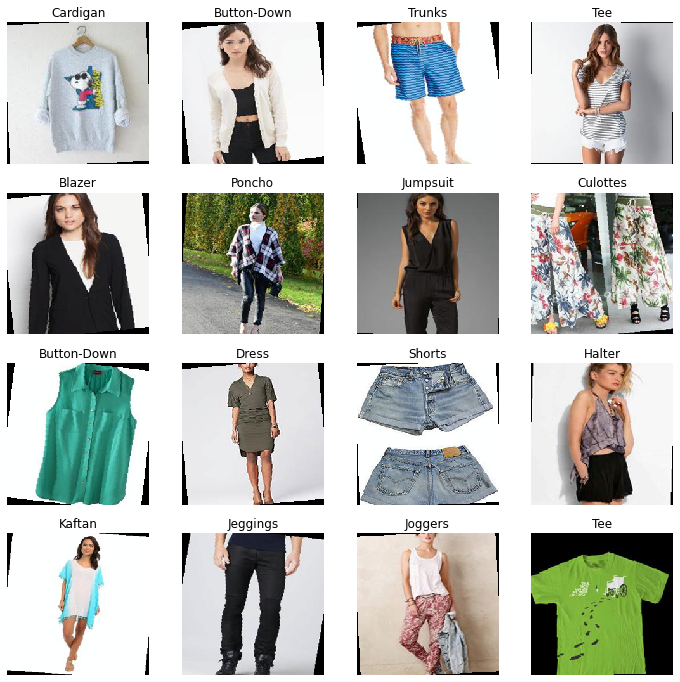

In [20]:
train_data_iter = iter(data_loaders['train'])
batch = train_data_iter.next()
images, labels = batch
plt.figure(figsize=(12, 12))
for index in range(0, min(16, len(images))):
    ax = plt.subplot(4, 4, index + 1)
    utils.imshow(images[index], ax=ax, title =classes_names[labels[index]] , normalize=True)



In [21]:
# print(images.min())
# print(images.max())
# print(labels.min())
# print(labels.max())


## Training

### <span style="color:#e76f51;">References</span>

- <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>


- Compare to benchmark
- Transfere learning on vgg16...
- Build smaller custom cnn

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment1: Transfer learning using vgg16:</u></b><br>


* <i>Because it is used in the paper of the reference above</i><br>
 
* <i>The descriptor has size <b>25088 1-dim vector</b> from any size from the image</i><br>


In [22]:
# Choose the pretrained model
model = models.vgg16(pretrained=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [23]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

In [24]:
# Build the network
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_p = 0.2):
        super().__init__()
        # Build the network
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.layers.extend([nn.Linear(n1, n2) for n1, n2 in zip(hidden_sizes, hidden_sizes[1:])])
        self.layers.extend([nn.Linear(hidden_sizes[-1], output_size)])
        # Build dropout
        self.drop_out = nn.Dropout(dropout_p)
    def forward(self, x):
        # iterate each layer
        for i, each in enumerate(self.layers):
            if i != len(self.layers) - 1:
                # get output of layer i
                x = each(x)
                # get acctivation relu
                x = F.relu(x)
                # make drop_out with p
                x = self.drop_out(x)
            else:
                # last layer = output layer
                x = each(x)
                x = F.log_softmax(x, dim=1)
        return x

In [25]:
# define netwrok
HEADEN_SIZES = [64]
DROPOUT = 0.2
classifier = Network(input_size=25088, output_size=N_CLASSES,
                     hidden_sizes=HEADEN_SIZES, dropout_p=DROPOUT)
# transfer learning
model.classifier = classifier
# Configure optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
# criterion
criterion = nn.NLLLoss()


In [26]:
# Save the checkpoint
checkpoint_dict = {}
checkpoint_dict['input_size'] = 25088
checkpoint_dict['output_size'] = N_CLASSES
checkpoint_dict['hidden_sizes'] = HEADEN_SIZES
checkpoint_dict['dropout_p'] = DROPOUT
checkpoint_dict['optimzier_state_dict'] = optimizer.state_dict()
checkpoint_dict['class_to_idx'] = image_datasets['train'].class_names
checkpoint_dict['arch'] = 'vgg16'
checkpoint_dict['criterion'] = criterion

In [27]:
mpl.rcParams['figure.figsize'] = 15, 15


In [28]:
cloth_utility_exp1 = Net_Utility(model, checkpoint_dict, optimizer, criterion, data_loaders, image_datasets, IMAGE_SIZE, delay=DELAY_EPOCHS_EARLY_STOPPING,  n_classes=N_CLASSES,
                                 save_checkpoint=True, is_train=IS_TRAIN, type_load_model=TYPE_LOAD_MODEL, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, print_every=PRINT_EVERY, debug=DEBUG)


Using device cuda
Train new model
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muhammed-elyamani. Use `wandb login --relogin` to force relogin
2022-06-17 18:28:31.048658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Starting training:
                Epochs:          5
                Batch size:      32
                Learning rate:   0.001
                Training size:   209
                valid size: 40
                Checkpoints:     True
                Device:          cuda
                Images size:  (224, 224)
            
Epoch 1/5:  15%|█▌        | 32/209 [00:00<00:05, 35.02img/s, loss (batch)=3.9]
1/5 .. train_loss: 3.896.. valid_loss: 4.024 .. valid_accuracy: 1.562%
Epoch 1/5:  31%|███       | 64/209 [00:03<00:08, 16.87img/s, loss (batch)=3.97]
1/5 .. train_loss: 3.969.. valid_loss: 4.078 .. valid_accuracy: 1.562%
Epoch 1/5:  46%|████▌     | 96/209 [00:05<00:06, 17.45img/s, loss (batch)=4.39]
1/5 .. train_loss: 4.390.. valid_loss: 3.896 .. valid_accuracy: 0.000%
Epoch 1/5:  61%|██████    | 128/209 [00:07<00:04, 17.58img/s, loss (batch)=3.99]
1/5 .. train_loss: 3.994.. valid_loss: 4.022 .. valid_accuracy: 0.000%
Epoch 1/5:  77%|███████▋  | 160/209 [00:08<00:02, 17.46img/s, loss (b

Winning: better model


Checkpoint 1 saved!
Epoch 2/5:  15%|█▌        | 32/209 [00:00<00:05, 32.95img/s, loss (batch)=3.63]
2/5 .. train_loss: 3.633.. valid_loss: 4.011 .. valid_accuracy: 1.562%
Epoch 2/5:  31%|███       | 64/209 [00:02<00:06, 22.13img/s, loss (batch)=3.44]
2/5 .. train_loss: 3.440.. valid_loss: 4.026 .. valid_accuracy: 3.125%
Epoch 2/5:  46%|████▌     | 96/209 [00:04<00:05, 20.38img/s, loss (batch)=3.56]
2/5 .. train_loss: 3.561.. valid_loss: 4.033 .. valid_accuracy: 3.125%
Epoch 2/5:  61%|██████    | 128/209 [00:06<00:04, 19.43img/s, loss (batch)=3.37]
2/5 .. train_loss: 3.374.. valid_loss: 4.018 .. valid_accuracy: 7.812%
Epoch 2/5:  77%|███████▋  | 160/209 [00:08<00:02, 18.75img/s, loss (batch)=3.27]
2/5 .. train_loss: 3.271.. valid_loss: 3.958 .. valid_accuracy: 0.000%
Epoch 2/5:  92%|█████████▏| 192/209 [00:10<00:00, 17.63img/s, loss (batch)=3.36]
2/5 .. train_loss: 3.357.. valid_loss: 4.072 .. valid_accuracy: 0.000%
Epoch 2/5: 100%|██████████| 209/209 [00:11<00:00, 15.63img/s, loss (bat

Epoch 3/5:  15%|█▌        | 32/209 [00:00<00:04, 38.11img/s, loss (batch)=2.99]
3/5 .. train_loss: 2.995.. valid_loss: 4.135 .. valid_accuracy: 0.000%
Epoch 3/5:  31%|███       | 64/209 [00:02<00:06, 23.97img/s, loss (batch)=3.15]
3/5 .. train_loss: 3.149.. valid_loss: 4.198 .. valid_accuracy: 0.000%
Epoch 3/5:  46%|████▌     | 96/209 [00:04<00:05, 21.18img/s, loss (batch)=3.14]
3/5 .. train_loss: 3.140.. valid_loss: 4.214 .. valid_accuracy: 0.000%
Epoch 3/5:  61%|██████    | 128/209 [00:05<00:04, 20.13img/s, loss (batch)=2.85]
3/5 .. train_loss: 2.855.. valid_loss: 4.271 .. valid_accuracy: 0.000%
Epoch 3/5:  77%|███████▋  | 160/209 [00:07<00:02, 19.26img/s, loss (batch)=3.09]
3/5 .. train_loss: 3.089.. valid_loss: 4.461 .. valid_accuracy: 0.000%
Epoch 3/5:  92%|█████████▏| 192/209 [00:09<00:00, 19.07img/s, loss (batch)=2.72]
3/5 .. train_loss: 2.724.. valid_loss: 4.355 .. valid_accuracy: 0.000%
Epoch 3/5: 100%|██████████| 209/209 [00:10<00:00, 16.66img/s, loss (batch)=3.06]
3/5 .. tra

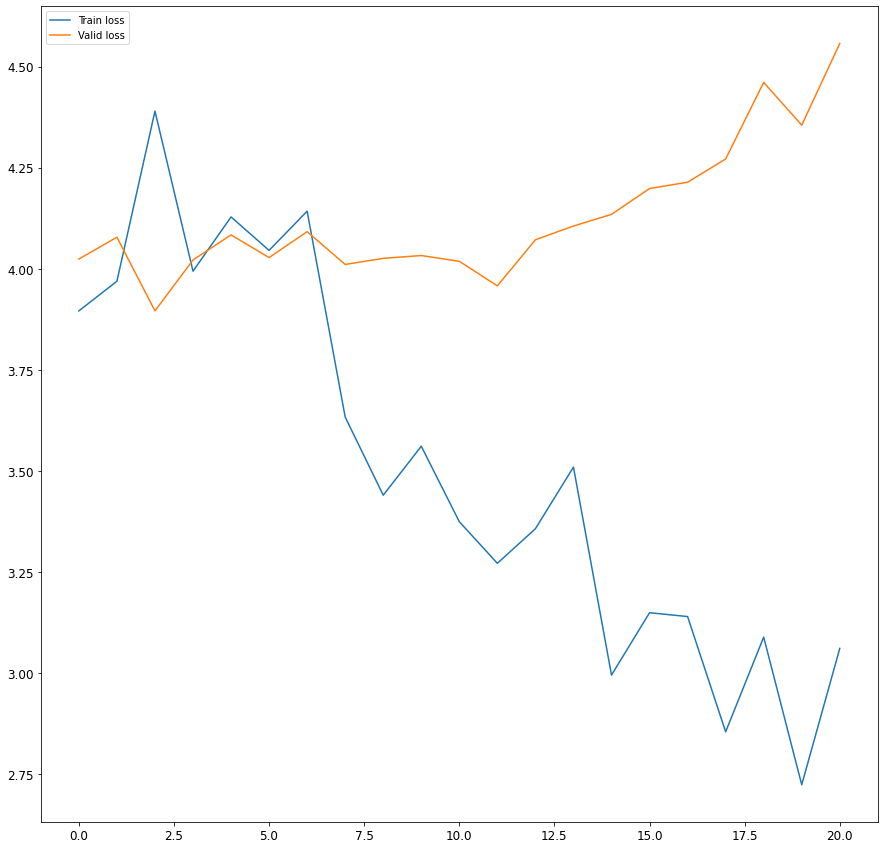

Having the best model

.. train_loss: 3.061.. valid_loss: 4.557 .. valid_accuracy: 0.000%


In [29]:
cloth_utility_exp1.train_model()

In [30]:
# cloth_utility_exp1.display_results()

## Load Model

In [31]:
load_model, _ = utils.find_last_version_model(
    dir_checkpoint=None, type_load_model=TYPE_LOAD_MODEL)
if load_model:
    model, optimizer = load_checkpoint(load_model, checkpoint_dict, Network)
else:
    print("no loaded models")

Loading the model and the hyperparameters
Model loaded from ./checkpoints/v5/best_checkpoint.pth
Info about checkpoint model:
Epoch: 1 .. train_loss: 4.142, valid_loss: 4.092, valid_accuracy: 0.000


In [32]:
# %pip install ptflops

In [33]:
# import torchvision.models as models
# import torch
# from ptflops import get_model_complexity_info

# with torch.cuda.device(0):
#   macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
#                                            print_per_layer_stat=True, verbose=True)
#   print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#   print('{:<30}  {:<8}'.format('Number of parameters: ', params))

## Testing

## Evaluation

## Visualiaztion